<a href="https://colab.research.google.com/github/ChecinskiBartlomiej/UM/blob/main/UM_hw_08.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Homework Assignment: Working with Other Loss Functions**

-------------------------------

During the class today, we reconstructed an **ellipse**. The ellipse was defined with two **foci** and $C$ (the sum of distances of the ellipse points from the foci).

To reconstruct the ellipse through optimization, we began with **$N$ points** scattered randomly in the 2D plane. Our goal was to adjust their positions so that they satisfy the elliptical constraint as closely as possible. We achieved this by minimizing the **error-related loss**, $L^{(2)}_{\text{ellipse}}$ which was defined in today's class with $\ell_2$ norm as:

$$
L^{(2)}_{\text{ellipse}} = \frac{1}{N} \sum_{i=1}^{N} \epsilon_i^2
$$

where
$$
 \epsilon_i = d_{i1} + d_{i2} - C
$$
where $N$ is the number of points, and $d_{i1}, d_{i2}$ are their distances to the two foci.

In the homework assignment you will experiment with 3 other loss definitions based on some other possible norms.



1. $\ell_0$ norm resulting in
  $$
  L^{(0)}_{\text{ellipse}} = \frac{1}{N} \sum_{i=1}^{N} \mathbf{1}(\epsilon_i \neq 0)
  $$
  - If you actually succeed to code this loss function, the question for you to answer in relation to $L^{(0)}_{\text{ellipse}}$ is why the training is not progressing with passing epochs.
  - If you actually fail to code this loss function, the question for you to answer is to explain the failure and reason out theoretically, why the training would not be progressing with passing epochs, anyway.

1. $\ell_1$ norm resulting in
  $$
  L^{(1)}_{\text{ellipse}} = \frac{1}{N} \sum_{i=1}^{N} |\epsilon_i|
  $$
  The question for you to answer in relation to $L^{(1)}_{\text{ellipse}}$ is why the training loss doesn't converge, even after the ellipse has been fully drawn.

1. $\ell_\infty$ norm resulting in
  $$
  L^{(\infty)}_{\text{ellipse}} =  \max_{i} |\epsilon_i|
  $$
  The question for you to answer in relation to $L^{(\infty)}_{\text{ellipse}}$ is why the training takes so long and it doesn't converge in the end, either.

## **Points to Note**

1. Draw both the shape that the points draw as they move, and the loss value after each epoch, just as we did in class today.

2. Note, that the purpose of this excercise is not that you reconstruct a perfect ellipse, but rather that you give it a try, and even if you fail you should document and explain the failure, and answer a question related to a given loss definition.

3. You can also play around with the learning rate to try to improve convergence.

## **Task & Deliverables**
  
   - Document your experiments (python code and charts) and **write down your conclusions** into the Colab notebook.
   - It is not strictly required, but **if you make a movie showing the optimization progress it will be considered a strong point of your solution**
     - You can make a movie programmatically as we did in clustering class (our second class) with EM clustering,
     - or, you can save to disk the image files with epoch charts and use an external tool to bind them into a movie. Provide links to movie files in the README.
   - Place the Colab notebook  with the solution in your **GitHub repository** for this course.
   - In your repository’s **README**, add a **link** to the notebook (and any movies you created) and also include an **“Open in Colab”** badge at the top of the notebook so it can be launched directly from GitHub.




In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def plot_results(loss_name, epoch, trajectories, loss_history=None):
    if loss_history is not None:
      fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    else:
      fig, axes = plt.subplots(1, 1, figsize=(6, 6))
      axes = [axes]
    points = np.array([trajectories[i][-1] for i in range(num_points)])
    axes[0].scatter(points[:, 0], points[:, 1], label=f'Points - Epoch {epoch}')
    f1 = focus1.detach().numpy()
    f2 = focus2.detach().numpy()
    axes[0].scatter([f1[0], f2[0]], [f1[1], f2[1]], color='red', marker='x', s=100, label='Foci')

    # Draw movement traces.
    for i in range(num_points):
        trajectory = np.array(trajectories[i])
        axes[0].plot(trajectory[:, 0], trajectory[:, 1], color='gray', linestyle='-', linewidth=0.5)

    axes[0].set_xlabel('X')
    axes[0].set_ylabel('Y')
    axes[0].legend()


    axes[0].grid()

    if loss_history is not None:
      axes[0].set_title(f'{loss_name}, points after Epoch {epoch}')
      axes[1].plot(loss_history, color='blue')
      axes[1].set_xlabel("Epoch")
      axes[1].set_ylabel("Loss")
      axes[1].set_title("Loss Convergence")
      axes[1].grid()
    else:
      axes[0].set_title(f'Points before Epoch {epoch}')

    plt.show()



[Epoch 0] element 0 of tensors does not require grad and does not have a grad_fn
Done: L_0


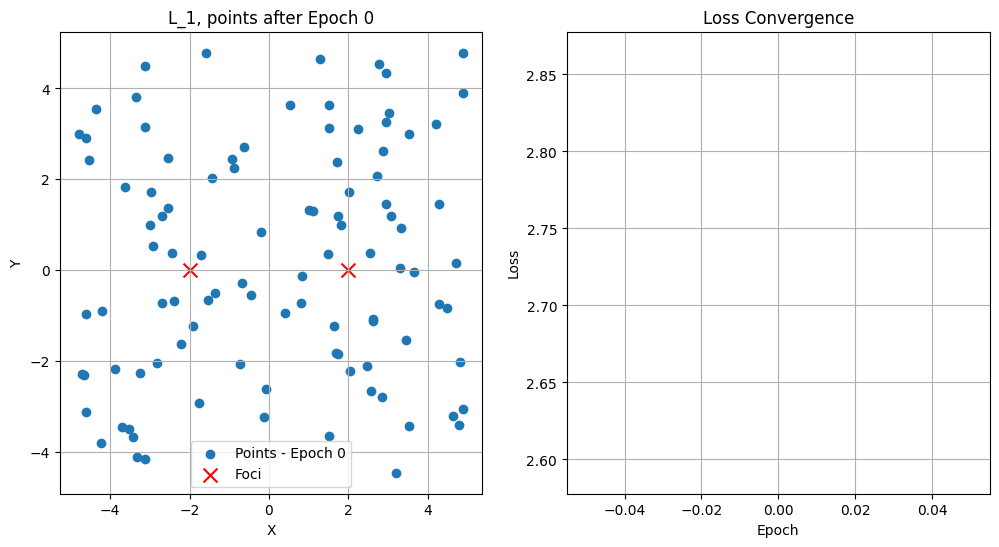

L_1, epoch 0: Loss = 2.727742


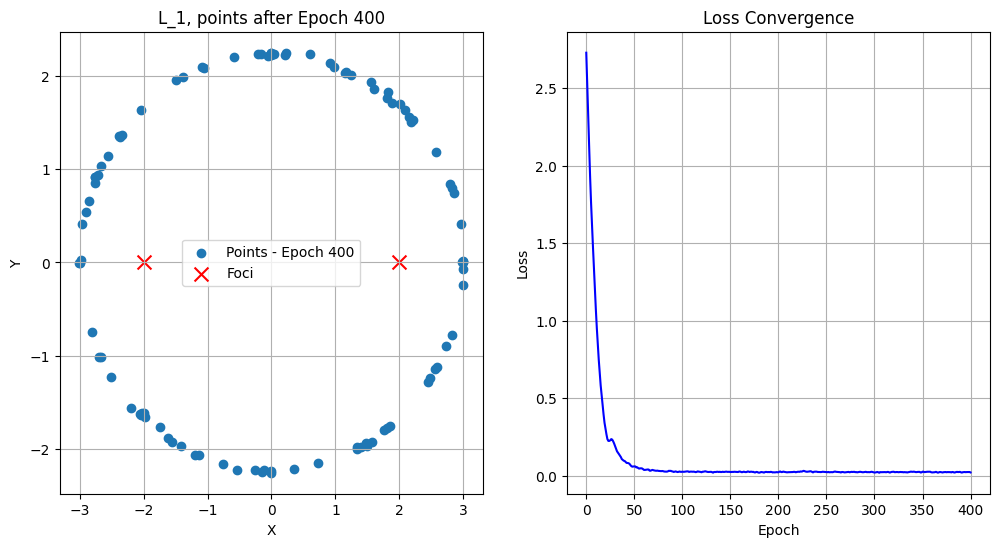

L_1, epoch 400: Loss = 0.020237


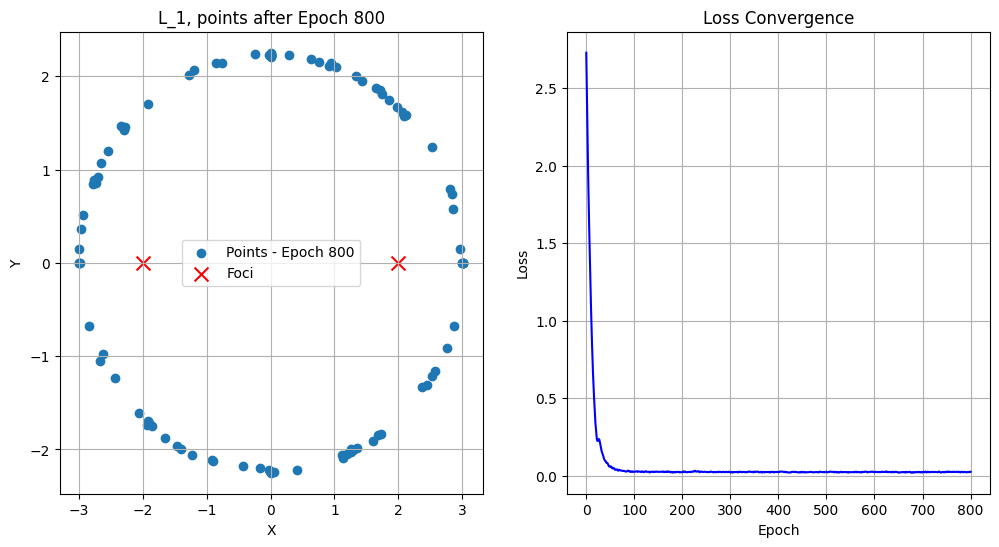

L_1, epoch 800: Loss = 0.023482


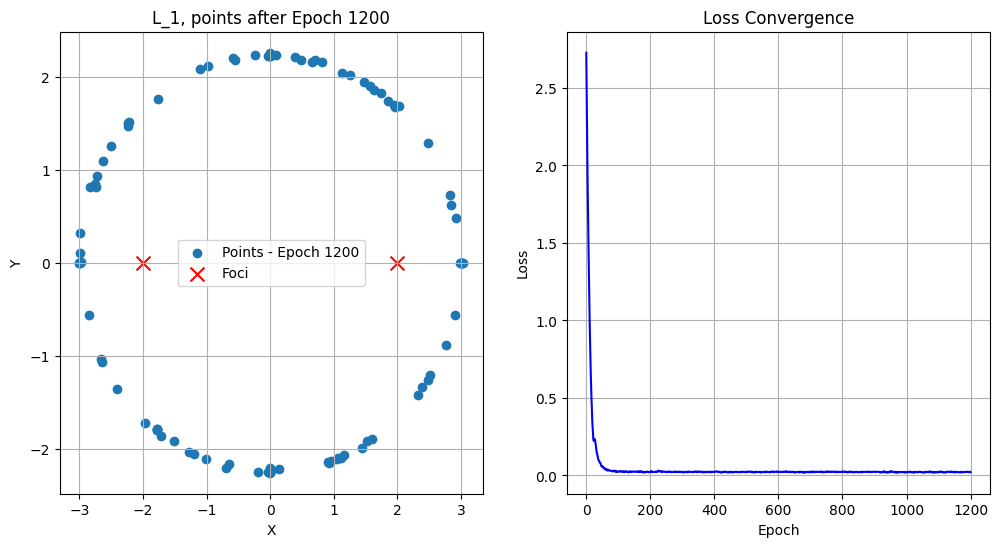

L_1, epoch 1200: Loss = 0.021045


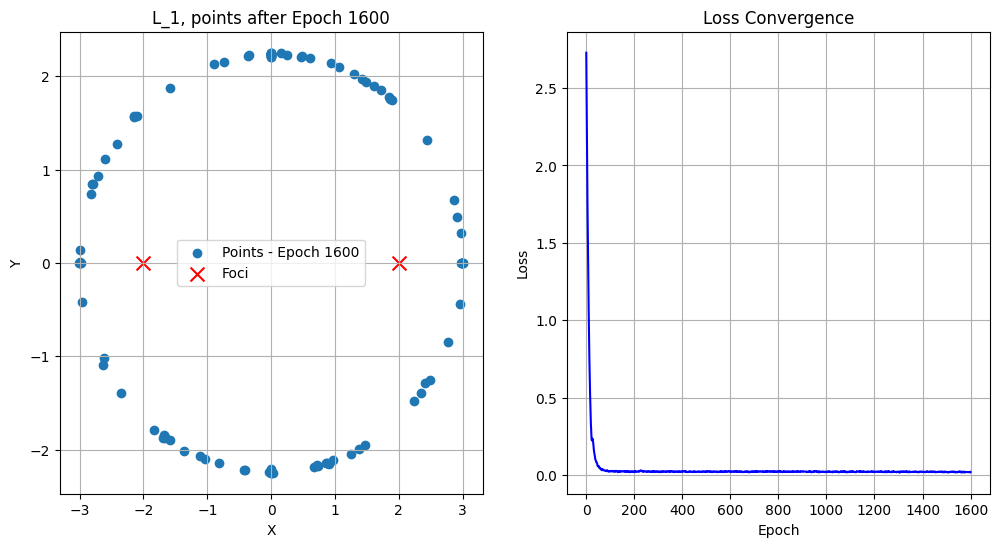

L_1, epoch 1600: Loss = 0.019637
Done: L_1


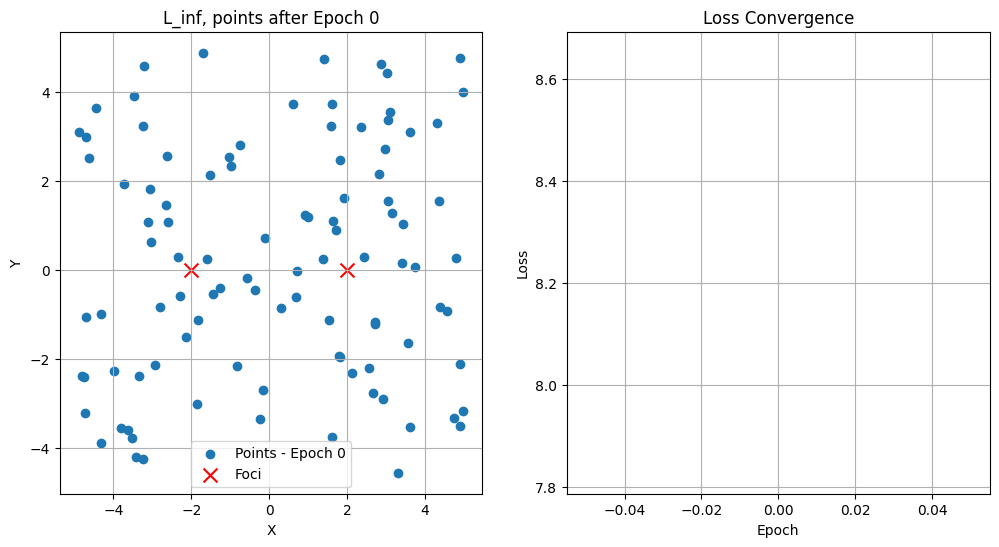

L_inf, epoch 0: Loss = 8.239019


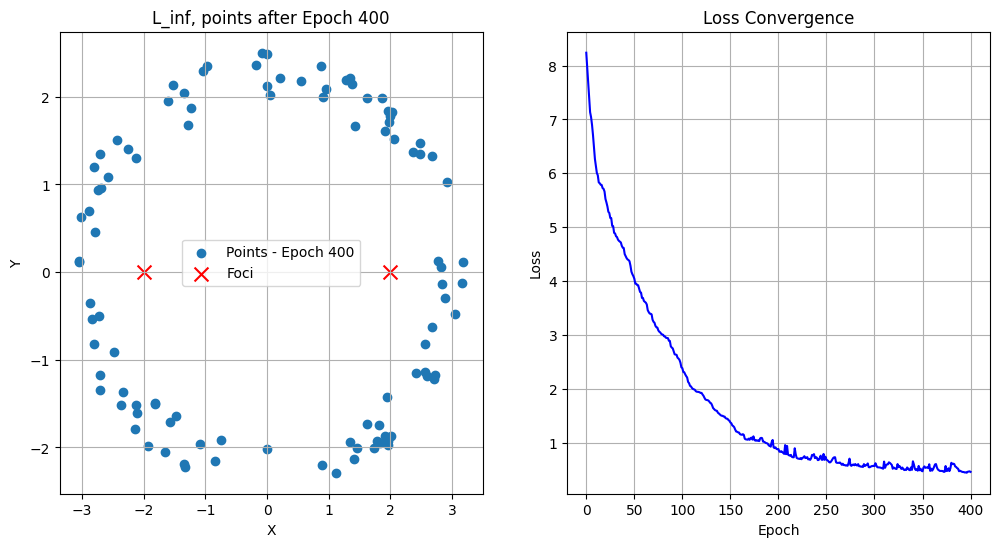

L_inf, epoch 400: Loss = 0.459833


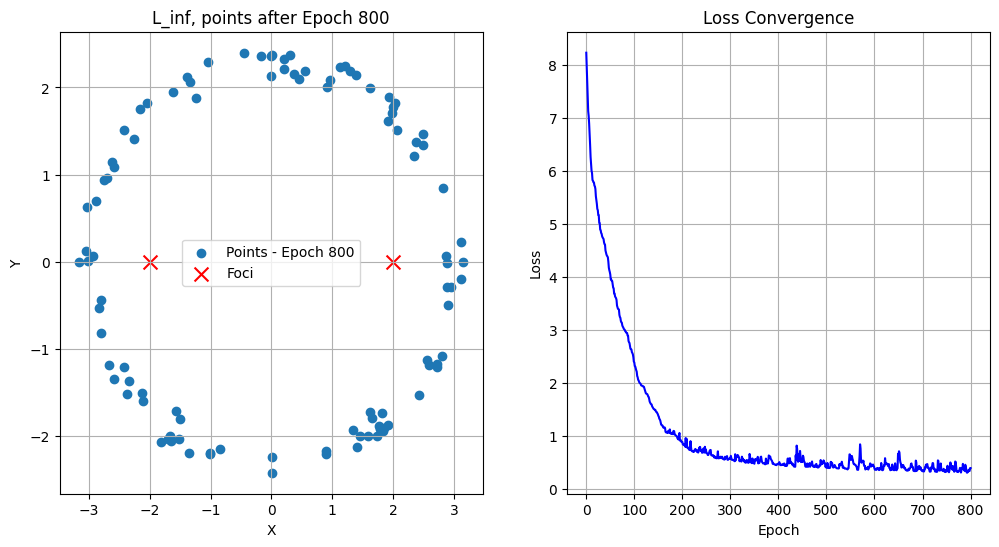

L_inf, epoch 800: Loss = 0.389378


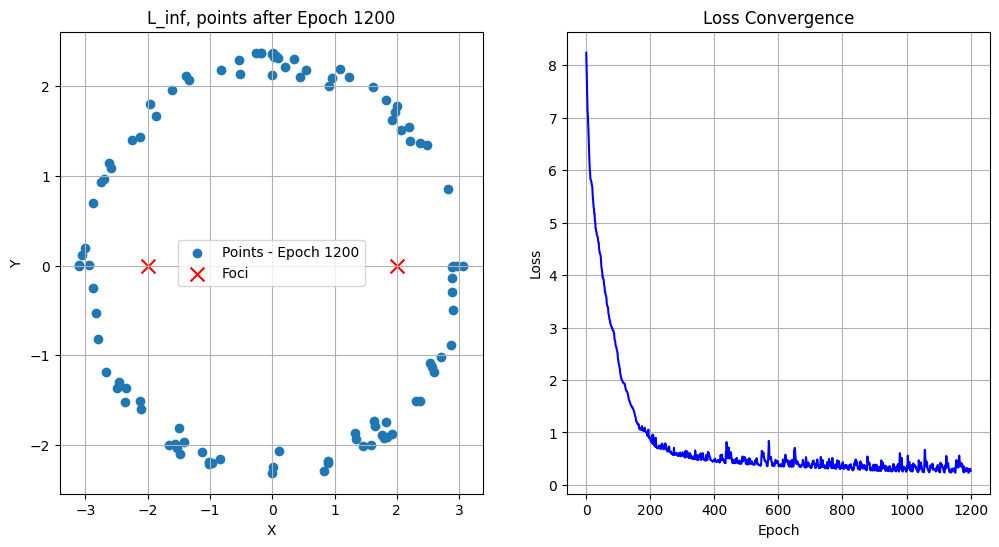

L_inf, epoch 1200: Loss = 0.266705


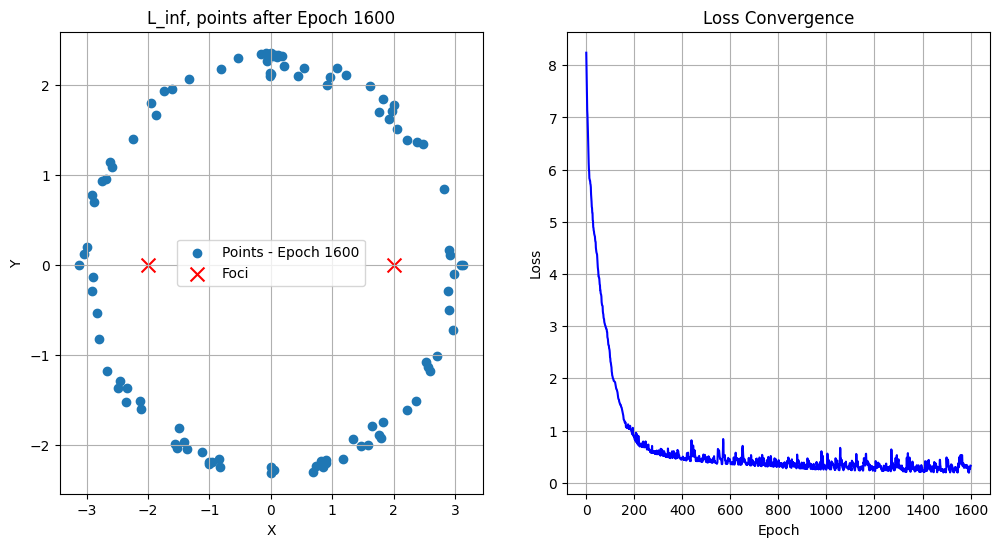

L_inf, epoch 1600: Loss = 0.326143
Done: L_inf


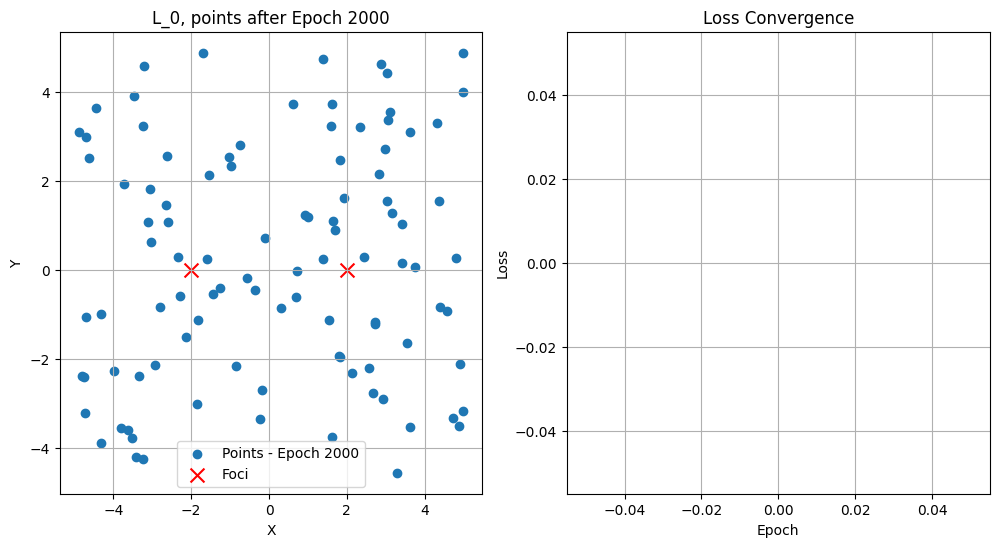

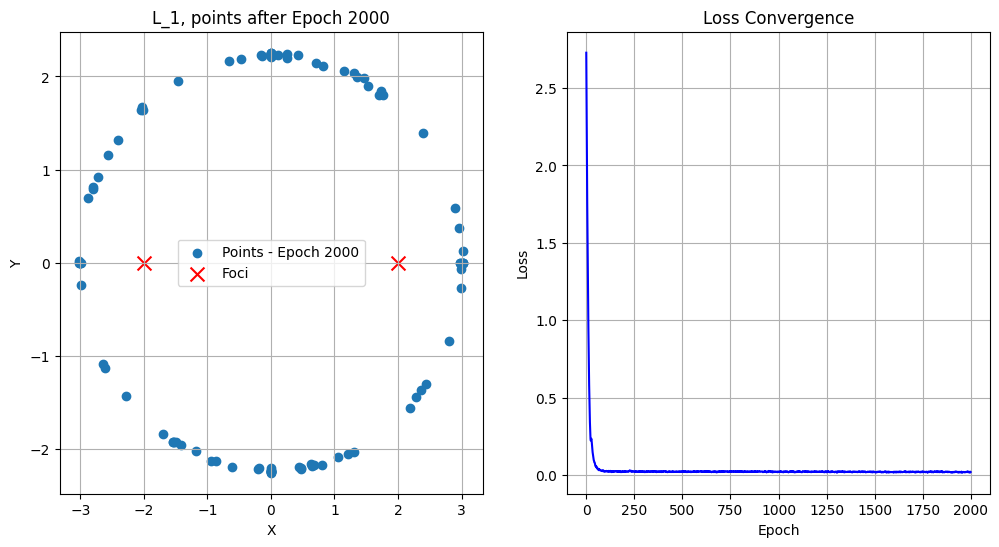

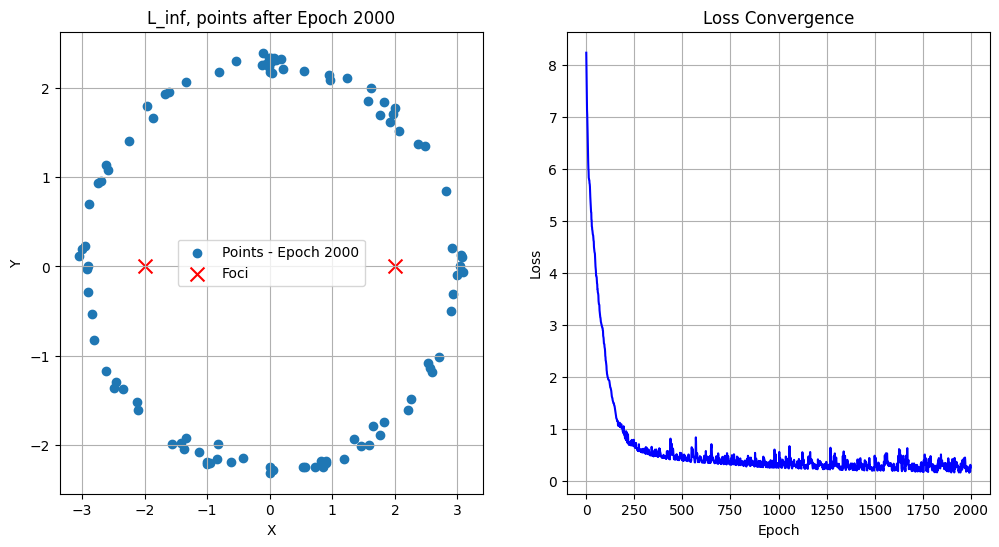

In [ ]:
# Fix the random seed for reproducibility.
torch.manual_seed(1)
np.random.seed(1)

# Define elipse parameters.
focus1 = torch.tensor([-2.0, 0.0])  # First focus.
focus2 = torch.tensor([2.0, 0.0])   # Second focus.
constant_sum = 6.0  # The sum of distances to the two foci.

# Initialize random 2D points from uniform distribution.
num_points = 100
points = torch.rand((num_points, 2)) * 10 - 5  # Uniformly distributed in [-5, 5].
points.requires_grad = True

# Dictionary of loss functions.
loss_fns = {
    'L_0': lambda eps: (eps != 0).float().mean(),
    'L_1': lambda eps: eps.abs().mean(),
    'L_inf': lambda eps: eps.abs().max()
}
def train(loss_name, loss_fn, init_points, num_epochs, lr=0.1):
  # Clone points, to work with copy.
  points = init_points.clone().detach().requires_grad_(True)
  optimizer = torch.optim.Adam([points], lr=lr)
  trajectories = [[] for _ in range(num_points)]
  loss_history = []

  for i in range(num_points):
      trajectories[i].append(points[i].detach().numpy())

  for epoch in range(num_epochs):
      optimizer.zero_grad()

      d1 = torch.norm(points - focus1, dim=1)
      d2 = torch.norm(points - focus2, dim=1)
      eps = d1 + d2 - constant_sum

      # Use one of loss functions from dictionary.
      loss = loss_fn(eps)
      # Try to compute gradients, if not possible inform about it and break the loop.
      try:
          loss.backward()
          optimizer.step()
      except RuntimeError as e:
          print(f"[Epoch {epoch}] {e}")
          break

      loss_history.append(loss.item())

      for i in range(num_points):
          trajectories[i].append(points[i].detach().numpy())

      # Plot results every 400th epoch.
      if epoch % 400 == 0:
          plot_results(loss_name, epoch, trajectories, loss_history)

      if epoch % 400 == 0:
          print(f"{loss_name}, epoch {epoch}: Loss = {loss.item():.6f}")

  return trajectories, loss_history


num_epochs = 2000
results = {}
for name, fn in loss_fns.items():
    traj, hist = train(name, fn, points, num_epochs)
    results[name] = (traj, hist)
    print(f"Done: {name}")

# Plot final results, last epoch.
for name,(traj,hist) in results.items():
    plot_results(name, num_epochs, traj, hist)

Let $x_{i,j}$ denote $j$-th coordinate (first or second) of $i$-th point.  $$\frac{\partial L_1}{\partial x_{i,j}}=\frac{\partial L_1}{\partial \epsilon_i}\frac{\partial \epsilon_i}{\partial x_{i,j}}=\frac{1}{N}sgn(\epsilon_i)\frac{\partial\epsilon_i}{\partial x_{i,j}}.$$ Notice that the direction of each optimization step depends on the sign of the error. Therefore, if we move the points inward and overshoot, the next step will push them outward. This process can repeat, causing the points to oscillate slightly. Although the ellipse may look visually correct, some points will be overshot and others undershot. In the next step this may reverse, but the overall loss remains roughly the same and does not converge to zero.

In $L_\infty$ case all but one partial derivatives are zero. This is why training takes so long. In one step we only udpate one point. The non zero derivative is up to scale the same as in $L_1$ case, so similar problem as in $L_1$ case occur and loss does not converge to zero.  

In $L_0$ case loss function is almost constanly equal to $1$. It is not equal to $1$ only when at least one point lies on the desired elipse which is almost impossible. Gradients are all zeros so we can't progress. Python outputs error.